## Modelling an Ace
Investigating factors that determine an ace and using a machine learning algorithm to predict if a serve would be an ace

In [102]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
    
# Downloading the csv file from Match Charting Project GitHub account into pandas

#Female Serve Dataset
url = "https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-stats-ServeBasics.csv"
df = pd.read_csv(url,error_bad_lines=False)

#Male Serve Dataset
url_male = 'https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-stats-ServeBasics.csv'
df_male = pd.read_csv(url_male, usecols=range(11),skip_blank_lines=True)

#Female Point by Point Breakdown
url_points = 'https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-points.csv' 
df_points = pd.read_csv(url_points,error_bad_lines=False,encoding='latin-1')

#Male Point by Point Breakdown
url_male_points = 'https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points.csv' 
df_male_points = pd.read_csv(url_male_points,error_bad_lines=False,encoding='latin-1')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [103]:
df.head()

match_id      row  pts  pts_won  \
0  20070901-W-US_Open-R32-Agnieszka_Radwanska-Mar...  1 Total   82       43   
1  20070901-W-US_Open-R32-Agnieszka_Radwanska-Mar...      1 1   46       24   
2  20070901-W-US_Open-R32-Agnieszka_Radwanska-Mar...      1 2   36       19   
3  20070901-W-US_Open-R32-Agnieszka_Radwanska-Mar...  2 Total   76       39   
4  20070901-W-US_Open-R32-Agnieszka_Radwanska-Mar...      2 1   50       33   

   aces  unret  forced_err  pts_won_lte_3_shots  wide  body   t  
0     1      1           2                   21    18    38  26  
1     1      1           2                   13    11    17  18  
2     0      0           0                    8     7    21   8  
3     2      3           2                   14    18    35  23  
4     2      3           2                   13    13    16  21

In [104]:
def percent(df):
    """
    Calculates % of aces, t, wide and body serves
    :param df: dataset 
    :returns df: Adds additional columns % of aces, serves for t, wide and body serves
    """
    df["t_%"] = df["t"]/df["pts"]
    df["body_%"] = df["body"]/df["pts"]
    df["wide_%"] = df["wide"]/df["pts"]
    df["aces_%"] = df["aces"]/df["pts"]
    df = df[(df["row"] == "1 Total") | (df["row"] == "2 Total")]
    df = df.drop(["unret","forced_err","pts_won_lte_3_shots"],axis=1)

    return df

In [105]:
def gender(df):
    """
    Calculates % of aces
    :param df: dataset 
    :returns value: % of aces
    """
    total_aces = df["aces"].sum()
    total_serves = df["pts"].sum()

    return (100*(total_aces/total_serves))

In [116]:
def type_diff(df_pts):
    """
    Calculates number of 1st and 2nd serves and number of aces
    :param df: dataset 
    :returns value: No. 1st serves, 1st serve aces, No. of 2nd serves, 2nd serve aces
    """
    total_fir_sev = df_pts["1stIn"].count()
    df_fir = df_pts[(df_pts["1stIn"] == 1.0)]
    aces_fir = df_fir["isAce"].sum()

    total_sec_sev = df_pts["2ndIn"].count()
    df_sec = df_pts[(df_pts["2ndIn"] == 1.0)]
    aces_sec = df_sec["isAce"].sum()

    return (total_fir_sev,aces_fir,total_sec_sev,aces_sec)


In [107]:
def accuracy(df):
    """
    Calculates accuacy of serves: Overall, 1st and 2nd
    :param df: dataset 
    :returns value: Overall accuracy, 1st serve accuracy and 2nd accuracy 
    """
    acc = 100*(df["1stIn"].sum()+df["2ndIn"].sum())/(df["1stIn"].count()+df["2ndIn"].count())
    acc1 = 100*(df["1stIn"].sum()/df["1stIn"].count())
    acc2 = 100*(df["2ndIn"].sum()/df["2ndIn"].count())

    return (acc, acc1, acc2)


In [108]:
def accuracy_2(df,df_2):
    """
    Calculates accuacy of serves without gender basis: Overall, 1st and 2nd
    :param df: dataset 
    :param df_2: 2nd dataset
    :returns value: Overall accuracy, 1st serve accuracy and 2nd accuracy 
    """
    acc = 100*(df["1stIn"].sum()+df["2ndIn"].sum()+df_2["1stIn"].sum()+df_2["2ndIn"].sum())/(df["1stIn"].count()+df["2ndIn"].count()+df_2["1stIn"].count()+df_2["2ndIn"].count())
    acc1 = 100*(df["1stIn"].sum()+df_2["1stIn"].sum())/(df["1stIn"].count()+df_2["1stIn"].count())
    acc2 = 100*(df["2ndIn"].sum()+df_2["2ndIn"].sum())/(df["2ndIn"].count()+df_2["2ndIn"].count())

    return (acc,acc1,acc2)

In [109]:
def serve_dir(df,serve_type):
    """
    Calculates ace % for a given serve type
    :param df: dataset 
    :serve_type: Serve type: 6 = T, 5 = Body and 4 = Wide
    :returns value: Returns Ace %
    """
    dir_tot = df["1st"].str.count(serve_type).sum()+df["2nd"].str.count(serve_type).sum()

    fir_ace = df[(df["isAce"] == True) & (df["1stIn"] == 1.0)]
    fir_ace_tot = fir_ace["1st"].str.count(serve_type).sum()

    sec_ace = df[(df["isAce"] == True) & (df["2ndIn"] == 1.0)]
    sec_ace_tot = sec_ace["2nd"].str.count(serve_type).sum()

    ace_per = (fir_ace_tot + sec_ace_tot)/dir_tot

    return (100*ace_per) 

In [110]:
def serve_dir_2(df,df_2,serve_type):
    """
    Calculates Overall,1st and 2nd serve ace % for a given serve type
    :param df: dataset 
    :serve_type: Serve type: 6 = T, 5 = Body and 4 = Wide
    :returns value: Returns Ace %, Total No. of Aces and Total No. of serves
    """
    dir_tot = df["1st"].str.count(serve_type).sum()+df["2nd"].str.count(serve_type).sum()

    fir_ace = df[(df["isAce"] == True) & (df["1stIn"] == 1.0)]
    fir_ace_tot = fir_ace["1st"].str.count(serve_type).sum()

    sec_ace = df[(df["isAce"] == True) & (df["2ndIn"] == 1.0)]
    sec_ace_tot = sec_ace["2nd"].str.count(serve_type).sum()

    dir_tot_2 = df_2["1st"].str.count(serve_type).sum()+df_2["2nd"].str.count(serve_type).sum()

    fir_ace_2 = df_2[(df_2["isAce"] == True) & (df_2["1stIn"] == 1.0)]
    fir_ace_tot_2 = fir_ace_2["1st"].str.count(serve_type).sum()

    sec_ace_2 = df_2[(df_2["isAce"] == True) & (df_2["2ndIn"] == 1.0)]
    sec_ace_tot_2 = sec_ace_2["2nd"].str.count(serve_type).sum()

    ace_per = (fir_ace_tot + sec_ace_tot+ fir_ace_tot_2 + sec_ace_tot_2)/(dir_tot + dir_tot_2)

    return (100*ace_per,fir_ace_tot + sec_ace_tot+ fir_ace_tot_2 + sec_ace_tot_2, dir_tot + dir_tot_2)  

In [111]:
def ace_per(df,df2):
    """
    Calculates ace % without gender bias
    :param df: dataset 
    :param df_2: 2nd dataset
    :returns value: Ace %
    """
    ace_per = (df["isAce"].sum()+df2["isAce"].sum())/(df["1stIn"].count()+df["2ndIn"].count()+df2["1stIn"].count()+df2["2ndIn"].count())
    return 100*ace_per


In [112]:
def gender_diff(df):
    """
    Calculates total aces and total serves
    :param df: dataset 
    :returns value: No. of Aces, No. of Serves
    """
    total_fir_sev = df["1stIn"].count()
    df_fir = df[(df["1stIn"] == 1.0)]
    aces_fir = df_fir["isAce"].sum()

    total_sec_sev = df["2ndIn"].count()
    df_sec = df[(df["2ndIn"] == 1.0)]
    aces_sec = df_sec["isAce"].sum()

    total_aces = aces_sec + aces_fir
    total_serve = total_fir_sev + total_sec_sev
    ace_per = 100*(total_aces/total_serve)

    return (ace_per)

In [50]:
frames = [df_points,df_male_points]
df_combine = pd.concat(frames)

In [115]:
overall_ace = type_diff(df_combine)
print("Overall ace percentage of dataset is: " + str(100*(overall_ace[1]+overall_ace[3])/(overall_ace[0] + overall_ace[2])))

Overall ace percentage of dataset is: 4.988293284041898


In [53]:
print("first serve ace percentage is: " + str(100*(overall_ace[1])/(overall_ace[0])))
print("second serve ace percentage is: " + str(100*(overall_ace[3])/(overall_ace[2])))

first serve ace percentage is: 6.6153941288377105
second serve ace percentage is: 0.6783210269883124


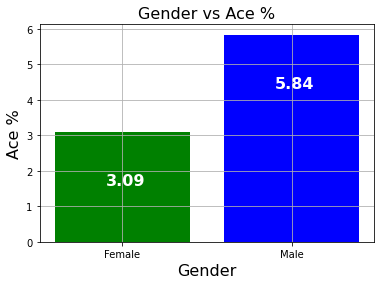

In [72]:
#Plots difference in Gender for Ace %

Gender = ["Female", "Male"]
Ratio_per_gender = [gender_diff(df_points),gender_diff(df_male_points)]

for index, value in enumerate(Ratio_per_gender):
    plt.text(index - 0.1, value -1.5, '{:.2f}'.format(value), fontsize = 16, color = 'white', weight = 'bold')

New_Colors = ['green','blue']
plt.bar(Gender, Ratio_per_gender, color=New_Colors)
plt.title('Gender vs Ace %', fontsize=16)
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Ace %', fontsize=16)
plt.grid(True)
#plt.savefig("Gender_Bar_Chart.jpg", quality = 95)
plt.show()

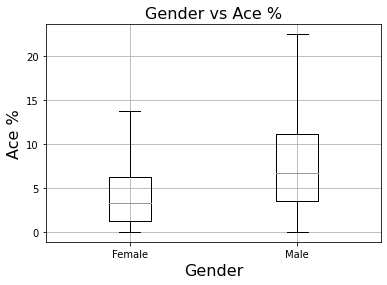

count    354800.000000
mean          4.392531
std           4.501812
min           0.000000
25%           1.294539
50%           3.278689
75%           6.264077
max          40.625000
Name: aces_%, dtype: float64 count    462600.000000
mean          8.028428
std           6.262369
min           0.000000
25%           3.529412
50%           6.722689
75%          11.111111
max          62.500000
Name: aces_%, dtype: float64


In [75]:
serve_fem = percent(df)
serve_male = percent(df_male)

female = 100*serve_fem["aces_%"]
male = 100*serve_male["aces_%"]

plt.grid(True)
plt.title('Gender vs Ace %', fontsize=16)
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Ace %', fontsize=16)
#plt.savefig("Gender_Box_Plot.jpg", quality = 95)
plt.boxplot ([female,male], labels = ["Female", "Male"], widths =0.25, showfliers=False)
plt.show()

print(100*serve_fem["aces_%"].describe(),100*serve_male["aces_%"].describe())

In [101]:
fem_list = type_diff(df_points)
male_list = type_diff(df_male_points)
Ratio_per_type = [serve_dir_2(df_male_points,df_points,"6")[0], serve_dir_2(df_male_points,df_points,"5")[0], serve_dir_2(df_male_points,df_points,"4")[0]]

print("first serve ace percentage is: " + str(100*(fem_list[1]+male_list[1])/(fem_list[0]+male_list[0])))
print("second serve ace percentage is: " + str(100*(fem_list[3]+male_list[3])/(fem_list[2]+male_list[2])))
print("female serve ace percentage is: " + str(100*(fem_list[1]+fem_list[3])/(fem_list[0]+fem_list[2])))
print("male serve ace percentage is: " + str(100*(male_list[1]+male_list[3])/(male_list[0]+male_list[2])))
print("T body serve ace percentage is: " + str(Ratio_per_type[0]))
print("Body serve ace percentage is: " + str(Ratio_per_type[0]))
print("Wide serve ace percentage is: " + str(Ratio_per_type[0]))

first serve ace percentage is: 6.6153941288377105
second serve ace percentage is: 0.6783210269883124
female serve ace percentage is: 3.0881177444451713
male serve ace percentage is: 5.839713775509554
T body serve ace percentage is: 7.275913729259123
Body serve ace percentage is: 7.275913729259123
Wide serve ace percentage is: 7.275913729259123


|  | Serve Type | Serve Type| Gender | Gender | Serve Direction | Serve Direction | Serve Direction |
| --- | --- | --- | --- | --- | --- | --- | --- |
| | 1st | 2nd | Female | Male | T | Body | Wide |
| Ace % | 6.62 | 0.68 | 3.09 | 5.84 | 7.28 | 0.07 | 5.35 |
| Factor difference | 9.74 |  | 1.89 |  | 104.00 | |  |

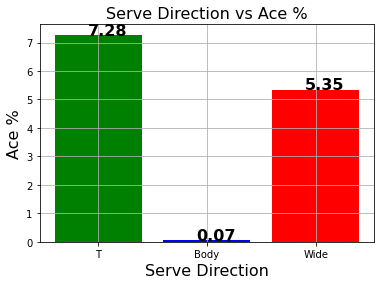

In [92]:
Serve_type = ["T", "Body", "Wide"]
Ratio_per_type = [serve_dir_2(df_male_points,df_points,"6")[0], serve_dir_2(df_male_points,df_points,"5")[0], serve_dir_2(df_male_points,df_points,"4")[0]]

Colors = ['green','blue',"red"]
for index, value in enumerate(Ratio_per_type):
    plt.text(index - 0.1, value, '{:.2f}'.format(value), fontsize = 16, weight = 'bold')
plt.bar(Serve_type, Ratio_per_type, color=Colors)
plt.title('Serve Direction vs Ace %', fontsize=16)
plt.xlabel('Serve Direction', fontsize=16)
plt.ylabel('Ace %', fontsize=16)
plt.grid(True)
#plt.savefig("Serve_direction_bar.jpg", quality = 95)
plt.show()

In [27]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np

In [28]:
df_new = df_points[["1st","1stIn","2nd","2ndIn","isAce"]]

In [29]:
df_new_male = df_male_points[["1st","1stIn","2nd","2ndIn","isAce"]]

In [30]:
#male = 1.0
#female = 2.0

df_new_male["gender"] = 1.0 
df_new["gender"] = 2.0

In [47]:
frames = [df_new,df_new_male]
df_combine = pd.concat(frames)

NameError: name 'df_new' is not defined

In [173]:
df_combine = pd.concat(frames)


In [33]:
result = df_combine["isAce"]

In [34]:
df_input = df_combine[["1stIn","2ndIn","gender"]]

In [35]:
df_input_clean = df_input.fillna(-1)

In [36]:
clf = RandomForestClassifier()

In [37]:
clf.fit(df_input_clean, result)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
print(clf.feature_importances_)

[0.36888784 0.5088072  0.12230496]


In [39]:
df_input.iloc[[0]]

1stIn  2ndIn  gender
0      0    1.0     2.0

In [40]:
print(clf.predict(df_input.iloc[[0]]))

[False]


In [41]:
#
print(clf.predict_proba(df_input.iloc[[0]]))

[[0.99441025 0.00558975]]


In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(df_input_clean, result, test_size=0.2)

In [43]:
X_train.shape, Y_train.shape

((566035, 3), (566035,))

In [44]:
X_test.shape, Y_test.shape

((141509, 3), (141509,))

In [56]:
clf = RandomForestClassifier(n_estimators = 200, max_depth = 2, random_state=0)

In [ ]:
df_input_xg = df_test_10[["1stIn","2ndIn","gender","1st_type","2nd_type"]]
result_xg = df_test_10["isAce"]

In [139]:
df_input_xg_clean = df_input_xg.fillna(-1)

In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(df_input_xg_clean, result, test_size=0.2)

In [141]:
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [142]:
print(clf.feature_importances_)

[0.38008285 0.30308545 0.0558602  0.09019588 0.17077562]


In [144]:
print(clf.predict(df_input_xg_clean.iloc[[0]]))

[False]


In [145]:
print(clf.predict_proba(df_input_xg_clean.iloc[[0]]))

[[0.98987011 0.01012989]]


In [146]:
predict = clf.predict(X_test)

In [147]:
print(clf.score(X_test, Y_test))

0.9298843183119095


In [148]:
Y_test.sum()/Y_test.count()

0.07011568168809051

In [149]:
print(np.count_nonzero(predict==0))
print(np.count_nonzero(predict))

141509
0


In [154]:
print(confusion_matrix(Y_test,predict))
print(classification_report(Y_test,predict))

[[131587      0]
 [  9922      0]]
              precision    recall  f1-score   support

       False       0.93      1.00      0.96    131587
        True       0.00      0.00      0.00      9922

   micro avg       0.93      0.93      0.93    141509
   macro avg       0.46      0.50      0.48    141509
weighted avg       0.86      0.93      0.90    141509



In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
from sklearn import svm

In [151]:
SVM = svm.LinearSVC()
SVM.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [152]:
y_pred = SVM.predict(X_test)

In [153]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))

[[131587      0]
 [  9922      0]]
              precision    recall  f1-score   support

       False       0.93      1.00      0.96    131587
        True       0.00      0.00      0.00      9922

   micro avg       0.93      0.93      0.93    141509
   macro avg       0.46      0.50      0.48    141509
weighted avg       0.86      0.93      0.90    141509



In [117]:
import sys
!{sys.executable} -m pip install xgboost

     |████████████████████████████████| 730 kB 4.8 MB/s 
     |████████████████████████████████| 36.1 MB 9.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/local/bin/python3 /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/pep517/in_process/_in_process.py prepare_metadata_for_build_wheel /var/folders/qv/byy3k63131s23x5dhtly2p240000gn/T/tmppikx0vmh
         cwd: /private/var/folders/qv/byy3k63131s23x5dhtly2p240000gn/T/pip-install-8qwnz0gw/scipy_52406d135af44fcdb262def460efc7ed
    Complete output (189 lines):
    setup.py:491: UserWarning: Unrecognized setuptools command ('dist_info --egg-base /private/var/folders/qv/byy3k63131s23x5dhtly2p240000gn/T/pip-modern-metadata-mn5no359'), proceeding with generating Cython sources and expanding templates
      warnings.warn("Unrecognized setuptools c

In [119]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [174]:
conditions = [(df_combine["1st"].str.contains("4")),(df_combine["1st"].str.contains("5")),(df_combine["1st"].str.contains("6"))]
values = ["4","5","6"]
conditions_2 = [(df_combine["2nd"].str.contains("4",na=False)),(df_combine["2nd"].str.contains("5",na=False)),(df_combine["2nd"].str.contains("6",na=False))]

In [175]:
df_test_10 = df_combine
df_test_10["1st_type"] = np.select(conditions,values)
df_test_10["2nd_type"] = np.select(conditions_2,values)

In [248]:
df_graph = df_test_10[["1stIn","2ndIn","gender","1st_type","2nd_type","isAce"]]

In [249]:
df_graph.head()

1stIn  2ndIn  gender 1st_type 2nd_type  isAce
0      0    1.0     2.0        6        6  False
1      1    NaN     2.0        4        0  False
2      0    1.0     2.0        6        6  False
3      1    NaN     2.0        5        0  False
4      1    NaN     2.0        4        0  False

In [176]:
df_input_xg = df_test_10[["1stIn","2ndIn","gender","1st_type","2nd_type"]]
result_xg = df_test_10["isAce"]

In [177]:
df_input_xg['1st_type'] = pd.to_numeric(df_input_xg['1st_type'])
df_input_xg['2nd_type'] = pd.to_numeric(df_input_xg['2nd_type'])

In [178]:
X_train_xg, X_test_xg, Y_train_xg, Y_test_xg = train_test_split(df_input_xg, result_xg, test_size=0.2)

In [275]:
model = XGBClassifier(scale_pos_weight=14)
model.fit(X_train_xg, Y_train_xg)

[20:05:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=4, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=14, subsample=1, tree_method='exact',
       use_label_encoder=True, validate_parameters=1, verbosity=None)

In [272]:
y_pred_xg = model.predict(X_test_xg)
predictions = [round(value) for value in y_pred_xg]

In [273]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test_xg, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.99%


In [274]:
print(confusion_matrix(Y_test_xg,predictions))
#print(classification_report(Y_test_xg,predictions))

[[66917 64704]
 [  401  9487]]
